<img src="ost-logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Machine Learning Projekt</b> <br> Lukas Mettler <br>Rico Good <br> Erich Meyer <br>
14.04.2021
</div>

# Machine Learning Projekt
## Einleitung

Beschreibung der Aufgabe, Anwendungsbereich und Bedeutung innerhalb dieses
Anwendungsbereichs

### Zielsetzung und Vorgehensweise
**Was soll erreicht werden?**
+ Vorhersage des Spielergebnisses

**Welchen Ansatz wählen Sie, um dieses Ziel zu erreichen?**
+ Aus den Spieldaten der Saison 2021 werden verschiedene Features generiert.
+ Für diese Features wird ein geeigneter Learner gesucht.
+ Der beste Learner wird für die Pipeline verwendet.


### Daten
https://www.basketball-reference.com/leagues/NBA_2021_games.html

https://www.basketball-reference.com/leagues/NBA_2021_ratings.html


### Ressourcen
https://towardsdatascience.com/predicting-the-outcome-of-nba-games-with-machine-learning-a810bb768f20

https://homepages.cae.wisc.edu/~ece539/fall13/project/AmorimTorres_rpt.pdf

https://github.com/JoshWeiner/NBA_Game_Prediction/blob/main/CIS_545_Final_Project.ipynb

https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/

https://www.youtube.com/watch?v=k7hSD_-gWMw

### Imports & Data

In [115]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time


### Game results

In [116]:
nba_2021_games = pd.read_csv("Data/NBA_2021_games.csv")
nba_2021_games['Date'] = pd.to_datetime(nba_2021_games['Date'])
nba_2021_games.head(10)


Date Start (ET)        Visitor/Neutral  PTS         Home/Neutral  \
0 2020-12-22      7:00p  Golden State Warriors   99        Brooklyn Nets   
1 2020-12-22     10:00p   Los Angeles Clippers  116   Los Angeles Lakers   
2 2020-12-23      7:00p      Charlotte Hornets  114  Cleveland Cavaliers   
3 2020-12-23      7:00p        New York Knicks  107       Indiana Pacers   
4 2020-12-23      7:00p             Miami Heat  107        Orlando Magic   
5 2020-12-23      7:00p     Washington Wizards  107   Philadelphia 76ers   
6 2020-12-23      7:30p   New Orleans Pelicans  113      Toronto Raptors   
7 2020-12-23      7:30p        Milwaukee Bucks  121       Boston Celtics   
8 2020-12-23      8:00p          Atlanta Hawks  124        Chicago Bulls   
9 2020-12-23      8:00p      San Antonio Spurs  131    Memphis Grizzlies   

   PTS.1 Unnamed: 6 Unnamed: 7  Attend. Notes  
0    125  Box Score        NaN      0.0   NaN  
1    109  Box Score        NaN      0.0   NaN  
2    121  Box Score        NaN    300.0   NaN  
3    121  Box Score        NaN      0.0   NaN  
4    113  Box Score        NaN   3396.0   NaN  
5    113  Box Score        NaN      0.0   NaN  
6     99  Box Score        NaN   3800.0   NaN  
7    122  Box Score        NaN      0.0   NaN  
8    104  Box Score        NaN      0.0   NaN  
9    119  Box Score        NaN      0.0   NaN

### Ranking


In [117]:
standings = pd.read_csv("Data/NBA_2021_ratings.csv", index_col="Team")
standings.head()

Rk Conf Div   W   L   W/L%   MOV    ORtg    DRtg  NRtg  \
Team                                                                           
Utah Jazz              1    W  NW  52  20  0.722  9.25  118.42  108.94  9.48   
Los Angeles Clippers   2    W   P  47  25  0.653  6.18  118.39  112.13  6.26   
Phoenix Suns           3    W   P  51  21  0.708  5.82  118.01  112.14  5.87   
Milwaukee Bucks        4    E   C  46  26  0.639  5.89  117.68  112.03  5.65   
Philadelphia 76ers     5    E   A  49  23  0.681  5.58  114.13  108.51  5.62   

                      MOV/A  ORtg/A  DRtg/A  NRtg/A  
Team                                                 
Utah Jazz              8.96  118.23  109.04    9.20  
Los Angeles Clippers   6.02  118.34  112.23    6.11  
Phoenix Suns           5.67  117.96  112.22    5.74  
Milwaukee Bucks        5.57  117.67  112.34    5.33  
Philadelphia 76ers     5.28  113.96  108.66    5.30

### Tidy up

In [118]:
drop = ["Start (ET)", "Unnamed: 6", "Unnamed: 7", "Attend.", "Notes"]
results = nba_2021_games.copy()
results.drop(drop, axis=1, inplace=True)
results.rename(columns = {"Visitor/Neutral":"Away_Team", "PTS":"Away_Points", "Home/Neutral":"Home_Team", "PTS.1":"Home_Points"}, inplace = True)
results['Game_ID'] = pd.util.hash_pandas_object(results)
results["Home_Win"] = results["Away_Points"] < results["Home_Points"]
results.head()




Date              Away_Team  Away_Points            Home_Team  \
0 2020-12-22  Golden State Warriors           99        Brooklyn Nets   
1 2020-12-22   Los Angeles Clippers          116   Los Angeles Lakers   
2 2020-12-23      Charlotte Hornets          114  Cleveland Cavaliers   
3 2020-12-23        New York Knicks          107       Indiana Pacers   
4 2020-12-23             Miami Heat          107        Orlando Magic   

   Home_Points               Game_ID  Home_Win  
0          125  10725087045398935357      True  
1          109  12714151703819587408     False  
2          121   3982069556598150946      True  
3          121  18261297810570432436      True  
4          113  17868637951929695198      True

In [119]:
win_percentage = results["Home_Win"].sum() / results["Home_Win"].count()
print("Home team win percentage: {0:.1f}%".format(100 * win_percentage))

Home team win percentage: 54.6%


## Explorative Datenanalyse

### Total wins and losses per team


In [120]:
drop = ["Rk", "Conf", "Div", "W/L%", "MOV", "ORtg", "DRtg", "NRtg", "MOV/A", "ORtg/A", "DRtg/A", "NRtg/A"]
total_wl = standings.copy()
total_wl.drop(drop, axis=1, inplace=True)
total_wl.head()

W   L
Team                        
Utah Jazz             52  20
Los Angeles Clippers  47  25
Phoenix Suns          51  21
Milwaukee Bucks       46  26
Philadelphia 76ers    49  23

<AxesSubplot:xlabel='Team'>

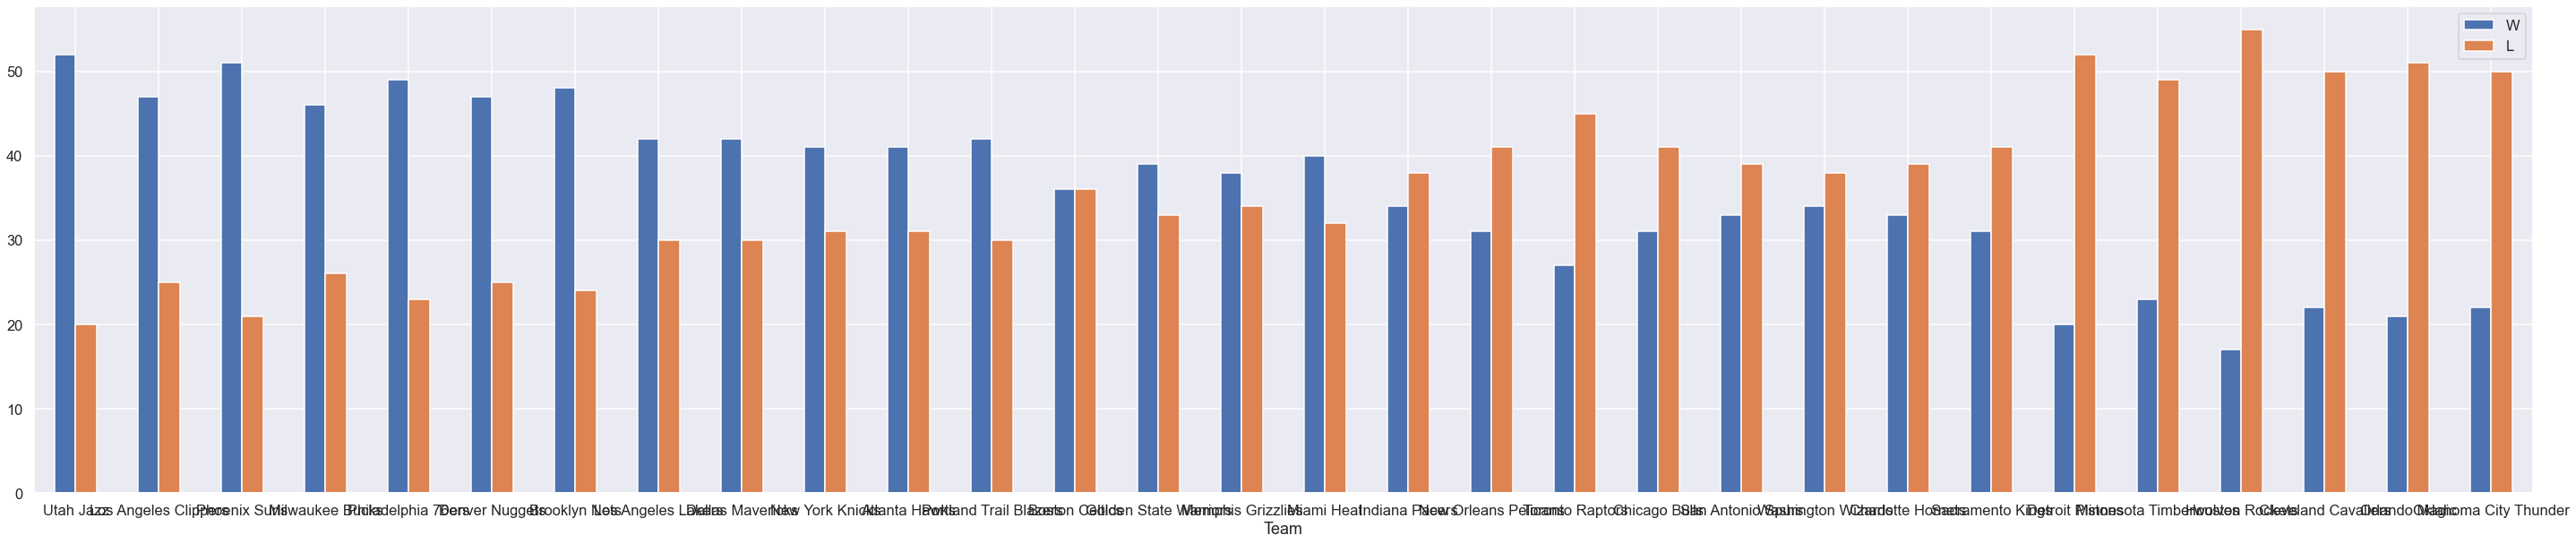

In [121]:
total_wl.plot.bar(figsize=(50,10), rot=0)

<AxesSubplot:>

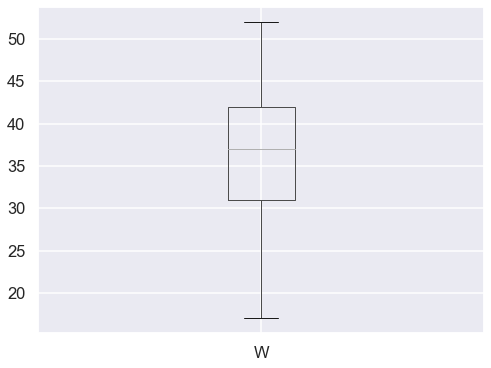

In [122]:
total_wl.boxplot(column="W", figsize=(8,6))

### Total points per team

In [123]:
total_pts_away = results.groupby('Away_Team')['Away_Points'].sum().reset_index()
total_pts_home = results.groupby('Home_Team')['Home_Points'].sum().reset_index()

total_pts = total_pts_away.merge(total_pts_home, left_on='Away_Team', right_on='Home_Team')
total_pts.drop(["Home_Team"], axis=1, inplace=True)
total_pts.rename(columns = {"Away_Team":"Team"}, inplace=True)
total_pts = total_pts.set_index("Team")
total_pts["Total_Points"] = total_pts["Home_Points"] + total_pts["Away_Points"]
total_pts.head()


Away_Points  Home_Points  Total_Points
Team                                                     
Atlanta Hawks             4230         4155          8385
Boston Celtics            4203         4225          8428
Brooklyn Nets             4296         4475          8771
Charlotte Hornets         4096         3902          7998
Chicago Bulls             4029         3940          7969

In [124]:

total_pts.plot.bar(figsize=(50,10), rot=0)

<AxesSubplot:xlabel='Team'>

Text(0, 0.5, 'Häufigkeit')

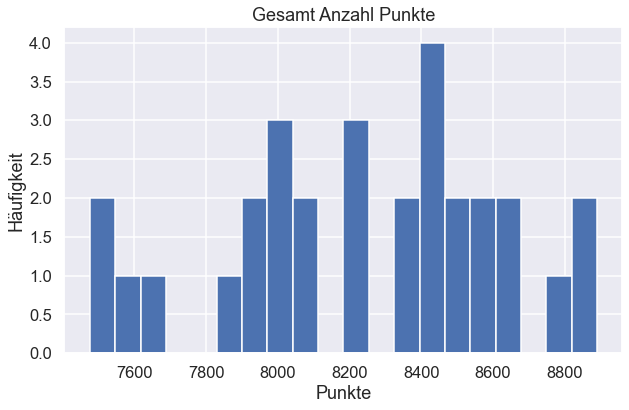

In [125]:
hist = total_pts["Total_Points"].hist(bins=20, figsize=(10,6))
hist.set_title("Gesamt Anzahl Punkte")
hist.set_xlabel('Punkte')
hist.set_ylabel("Häufigkeit")

## Erkenntnis
Wie man sieht hat die gesamte Anzahl erzielte Punkte in einer Saison keinen Einfluss wie gut ein Team ist.



### F-Score
Das F-Mass kombiniert Genauigkeit und Trefferquote mittels des gewichteten harmonischen Mittels

In [126]:
from sklearn.metrics import f1_score
y_true = results["Home_Win"].values
y_pred = [1] * len(y_true)
baseline = f1_score(y_true, y_pred, pos_label=None, average="weighted")
print("Accuracy: {:.4f}".format(baseline))

Accuracy: 0.3860


### Last win & Win streak feature

In [127]:
from collections import defaultdict

results["Home_Last_Win"] = False
results["Away_Last_Win"] = False
results["Home_Win_Streak"] = 0
results["Away_Win_Streak"] = 0

won_last = defaultdict(int)
win_streak = defaultdict(int)

for index, row in results.iterrows():
    home_team = row["Home_Team"]
    away_team = row["Away_Team"]
    row["Home_Last_Win"] = won_last[home_team]
    row["Away_Last_Win"] = won_last[away_team]
    row["Home_Win_Streak"] = win_streak[home_team]
    row["Away_Win_Streak"] = win_streak[away_team]
    results.loc[index] = row
    won_last[home_team] = row["Home_Win"]
    won_last[away_team] = not row["Home_Win"]

    if row["Home_Win"]:
        win_streak[home_team] += 1
        win_streak[away_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[away_team] += 1

results.loc[100:110]


Date               Away_Team  Away_Points               Home_Team  \
100 2021-01-05               Utah Jazz           96           Brooklyn Nets   
101 2021-01-05      Los Angeles Lakers           94       Memphis Grizzlies   
102 2021-01-05  Minnesota Timberwolves          116          Denver Nuggets   
103 2021-01-05       San Antonio Spurs          116    Los Angeles Clippers   
104 2021-01-05           Chicago Bulls          111  Portland Trail Blazers   
105 2021-01-06         Houston Rockets          107          Indiana Pacers   
106 2021-01-06     Cleveland Cavaliers           94           Orlando Magic   
107 2021-01-06      Washington Wizards          136      Philadelphia 76ers   
108 2021-01-06       Charlotte Hornets          102           Atlanta Hawks   
109 2021-01-06          Boston Celtics          107              Miami Heat   
110 2021-01-06               Utah Jazz          100         New York Knicks   

     Home_Points               Game_ID  Home_Win Home_Last_Win Away_Last_Win  \
100          130    293768642946528169      True         False          True   
101           92  10589249099003170092     False         False          True   
102          123  11712755819492254176      True          True         False   
103          113   5120052148934811357     False          True         False   
104          108  12627128016219858272     False         False          True   
105          114   1287171933556885594      True          True         False   
106          105   4632271047736604676      True          True         False   
107          141   8913190472129899879      True          True          True   
108           94   2478624970383574194     False         False         False   
109          105   4316320257516700645     False          True          True   
110          112   3533440777656180770      True          True         False   

     Home_Win_Streak  Away_Win_Streak  
100                0                2  
101                0                3  
102                1                0  
103                1                0  
104                0                1  
105                1                0  
106                1                0  
107                4                2  
108                0                0  
109                1                2  
110                2                0

### Classification with decision tree

In [128]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

from sklearn.model_selection import cross_val_score

X_winstreak = results[["Home_Last_Win", "Away_Last_Win", "Home_Win_Streak", "Away_Win_Streak"]].values
scores = cross_val_score(clf, X_winstreak, y_true)
base_feat_dt = np.mean(scores)
print("Accuracy: {0:.4f}".format(base_feat_dt))

Accuracy: 0.5290


### Home team ranks higher feature


In [129]:
def home_team_ranks_higher(row):
    home_team = row["Home_Team"]
    away_team = row["Away_Team"]
    home_rank = standings.loc[home_team]["Rk"]
    away_rank = standings.loc[away_team]["Rk"]
    return home_rank < away_rank

results["Home_Ranks_Higher"] = results.apply(home_team_ranks_higher, axis=1)
results.head()[["Date", "Home_Team", "Home_Points", "Away_Team", "Away_Points", "Home_Win", "Home_Ranks_Higher"]]

Date            Home_Team  Home_Points              Away_Team  \
0 2020-12-22        Brooklyn Nets          125  Golden State Warriors   
1 2020-12-22   Los Angeles Lakers          109   Los Angeles Clippers   
2 2020-12-23  Cleveland Cavaliers          121      Charlotte Hornets   
3 2020-12-23       Indiana Pacers          121        New York Knicks   
4 2020-12-23        Orlando Magic          113             Miami Heat   

   Away_Points  Home_Win  Home_Ranks_Higher  
0           99      True               True  
1          116     False              False  
2          114      True              False  
3          107      True              False  
4          107      True              False

In [130]:
X_homehigher = results[["Home_Last_Win", "Away_Last_Win", "Home_Win_Streak", "Away_Win_Streak", "Home_Ranks_Higher"]].values
clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X_homehigher, y_true)

print("Accuracy: {0:.4f}".format(np.mean(scores)))

Accuracy: 0.6398


### Grid search


In [131]:
from sklearn.model_selection import GridSearchCV

para_space = {"max_depth": np.linspace(1, 20, 20)}
# print(para_space)
clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, para_space)
grid.fit(X_homehigher, y_true)
teams_dt = grid.best_score_
print("Accuracy: {0:.4f}".format(teams_dt))

Accuracy: 0.6661


### ELO feature

In [132]:
start_elo = 1500
elo_width = 400
k_factor = 64

results["Home_Elo"] = start_elo
results["Away_Elo"] = start_elo

# def get_k(mov, elo_diff):
#   k = 20
#   if mov > 0:
#     return k * (mov + 3)**(0.8) / (7.5 + 0.006*(elo_diff))
#   else:
#     return k * (-mov + 3)**(0.8) / (7.5 + 0.006*(-elo_diff))

def update_elo(row):
  if row["Home_Win"]:
    winner_elo = get_previous_elo(row, row["Home_Team"])
    # winner_mov = standings.loc[row["Home_Team"]]["MOV/A"]
    loser_elo = get_previous_elo(row, row["Away_Team"])
  else:
    winner_elo = get_previous_elo(row, row["Away_Team"])
    # winner_mov = standings.loc[row["Away_Team"]]["MOV/A"]
    loser_elo = get_previous_elo(row, row["Home_Team"])

  # k_factor = get_k(winner_mov, (winner_elo - loser_elo))
  expected_win = expected_result(winner_elo, loser_elo)
  change_in_elo = k_factor * (1-expected_win)
  winner_elo += change_in_elo
  loser_elo -= change_in_elo
  
  return winner_elo, loser_elo

def expected_result(elo_a, elo_b):
  expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
  return expect_a

def get_previous_elo(row, team):
  try:
    previous_game = results[results["Date"] < row["Date"]][(results["Home_Team"] == team) | (results["Away_Team"] == team)].sort_values(by = 'Date').tail(1).iloc[0]
  except:
    previous_game = row

  if team == previous_game["Home_Team"]:
    return previous_game["Home_Elo"]
  else:
    return previous_game["Away_Elo"]

for index, row in results.iterrows():
  elo_tuple = update_elo(row)
  if row["Home_Win"]:
    results.at[index, "Home_Elo"] = elo_tuple[0]
    results.at[index, "Away_Elo"] = elo_tuple[1]
  else:
    results.at[index, "Home_Elo"] = elo_tuple[1]
    results.at[index, "Away_Elo"] = elo_tuple[0]

results[["Date", "Home_Team", "Home_Points", "Away_Team", "Away_Points", "Home_Win", "Home_Elo", "Away_Elo"]]

<ipython-input-132-88dd81000b05>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  previous_game = results[results["Date"] < row["Date"]][(results["Home_Team"] == team) | (results["Away_Team"] == team)].sort_values(by = 'Date').tail(1).iloc[0]


Date             Home_Team  Home_Points              Away_Team  \
0    2020-12-22         Brooklyn Nets          125  Golden State Warriors   
1    2020-12-22    Los Angeles Lakers          109   Los Angeles Clippers   
2    2020-12-23   Cleveland Cavaliers          121      Charlotte Hornets   
3    2020-12-23        Indiana Pacers          121        New York Knicks   
4    2020-12-23         Orlando Magic          113             Miami Heat   
...         ...                   ...          ...                    ...   
1097 2021-05-25          Phoenix Suns          102     Los Angeles Lakers   
1098 2021-05-25  Los Angeles Clippers          121       Dallas Mavericks   
1099 2021-05-26    Philadelphia 76ers          120     Washington Wizards   
1100 2021-05-26       New York Knicks          101          Atlanta Hawks   
1101 2021-05-26             Utah Jazz          141      Memphis Grizzlies   

      Away_Points  Home_Win  Home_Elo  Away_Elo  
0              99      True      1532      1468  
1             116     False      1468      1532  
2             114      True      1532      1468  
3             107      True      1532      1468  
4             107      True      1532      1468  
...           ...       ...       ...       ...  
1097          109     False      1637      1598  
1098          127     False      1450      1598  
1099           95      True      1634      1465  
1100           92      True      1631      1620  
1101          129      True      1586      1583  

[1102 rows x 8 columns]

In [133]:
X_higher_elo = results[["Home_Last_Win", "Away_Last_Win", "Home_Win_Streak", "Away_Win_Streak", "Home_Ranks_Higher", "Home_Elo", "Away_Elo"]].values
clf = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(clf, X_higher_elo, y_true)
elo_dt = np.mean(scores)
print("Accuracy: {0:.4f}".format(elo_dt))

Accuracy: 0.7359


In [134]:
from sklearn.model_selection import GridSearchCV

para_space = {"max_depth": np.linspace(1, 20, 20)}
# print(para_space)
clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, para_space)
grid.fit(X_higher_elo, y_true)
elo_dt_gs = grid.best_score_
print("Accuracy: {0:.4f}".format(elo_dt_gs))

Accuracy: 0.7913


### Encoding teams


In [135]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encoding = LabelEncoder()
encoding.fit(results["Home_Team"].values)

home_teams = encoding.transform(results["Home_Team"].values)
away_teams = encoding.transform(results["Away_Team"].values)
X_teams = np.vstack([home_teams, away_teams]).T
X_teams[:5], X_teams.shape

(array([[ 2,  9],
        [13, 12],
        [ 5,  3],
        [11, 19],
        [21, 15]]),
 (1102, 2))

In [136]:
onehot = OneHotEncoder()
X_teams = onehot.fit_transform(X_teams).todense()
X_teams.shape

X_all = np.hstack([X_higher_elo, X_teams])
X_all.shape

(1102, 67)

### Random forest Classifier

In [137]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_higher_elo, y_true)
elo_rf = np.mean(scores)
print("Accuracy: {0:.4f}".format(np.mean(scores)))

Accuracy: 0.7985


In [138]:
param_space = {
    # "max_features": [2, 10, , "auto"],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 2, 4, 6], 
}
clf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(clf, param_space)
grid_rf.fit(X_higher_elo, y_true)
elo_rf_gs = grid_rf.best_score_
print("Accuracy: {0:.4f}".format(elo_rf))
print(grid.best_estimator_)

Accuracy: 0.7985
DecisionTreeClassifier(max_depth=6.0, random_state=42)


### with encoded teams

In [139]:
param_space = {
    # "max_features": [2, 10, , "auto"],
    "n_estimators": [50, 100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 2, 4, 6], 
}
clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_space)
grid.fit(X_all, y_true)
all_rf_gs = grid.best_score_
print("Accuracy: {0:.4f}".format(all_rf_gs))
print(grid.best_estimator_)

Accuracy: 0.8030
RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=42)


### Logistic regression

#### higher elo

In [140]:
from sklearn.linear_model import LogisticRegression
X_higher_elo = results[["Home_Last_Win", "Away_Last_Win", "Home_Win_Streak", "Away_Win_Streak", "Home_Ranks_Higher", "Home_Elo", "Away_Elo"]].values
clf_log_reg = LogisticRegression(random_state=42, solver='liblinear', multi_class="auto")
clf_log_reg.fit(X_higher_elo, y_true)
elo_logreg = clf_log_reg.score(X_higher_elo, y_true)
print("Accuracy: {0:.4f}".format(elo_logreg))

Accuracy: 0.8312


#### with encoded teams

In [141]:
X_higher_elo = results[["Home_Last_Win", "Away_Last_Win", "Home_Win_Streak", "Away_Win_Streak", "Home_Ranks_Higher", "Home_Elo", "Away_Elo"]].values
clf_log_reg = LogisticRegression(random_state=42, solver='liblinear', multi_class="auto")
clf_log_reg.fit(X_all, y_true)
all_logreg = clf_log_reg.score(X_all, y_true)
print("Accuracy: {0:.4f}".format(all_logreg))

Accuracy: 0.8539


---

Text(0, 0.5, 'Accuracy')

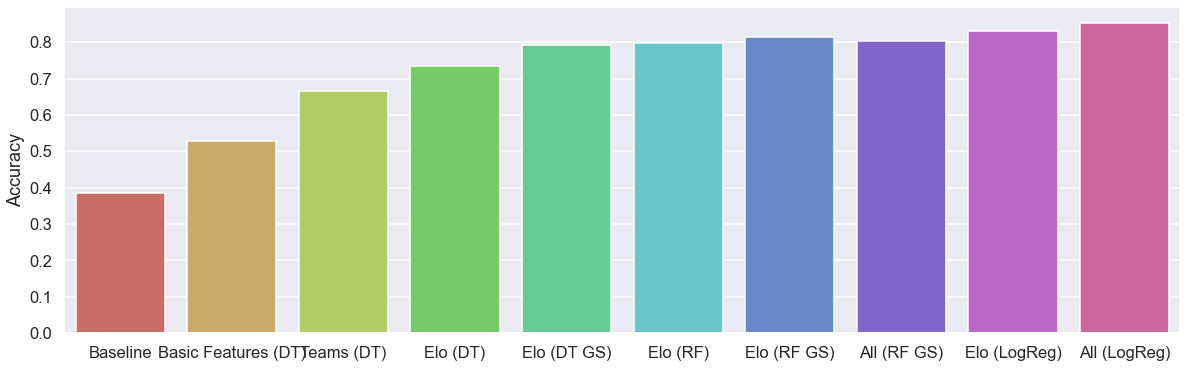

In [142]:
labels = ["Baseline", "Basic Features (DT)", "Teams (DT)", "Elo (DT)", "Elo (DT GS)", "Elo (RF)", "Elo (RF GS)", "All (RF GS)", "Elo (LogReg)", "All (LogReg)" ]
scores = [baseline, base_feat_dt, teams_dt, elo_dt, elo_dt_gs, elo_rf, elo_rf_gs, all_rf_gs, elo_logreg, all_logreg]
sns.set(style="darkgrid", context="talk")
fig, bars = plt.subplots(figsize = (20,6))
bars = sns.barplot(x=labels, y=scores, palette = "hls")
bars.set_ylabel("Accuracy")


## Entscheid

Erstaunlicherweise hat der Logistic Regression Learner am besten abgeschnitten. Mit dem haben wir nicht gerechnet, da alle Anderen die eine ähnliche Aufgabe gelöst haben, mit dem Random Forest am besten abgeschnitten.

Überrascht hat uns auch, dass wir ~10% genauer sind als Andere, dies liegt wohl am Elo-Ranking. Im Barplot von oben, kann man gut sehen, dass sobald das Elo Feature implementiert wurde, die Genauigkeit um ca. 10% gestiegen ist.

## Pipeline


In [143]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score



In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_higher_elo, y_true, test_size = 0.25)

pipe = Pipeline([('pca', PCA(n_components = 7)), ("std", StandardScaler()), ("logistic_regression", LogisticRegression(random_state=42, solver='liblinear', multi_class="auto"))], verbose = True)
pipe.fit(X_train, y_train)

print(accuracy_score(y_test, pipe.predict(X_test)))

[Pipeline] ............... (step 1 of 3) Processing pca, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline]  (step 3 of 3) Processing logistic_regression, total=   0.0s
0.8115942028985508


## Feature importances random forest tree without encoded teams

In [146]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    grid_rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=["Home_Last_Win", "Away_Last_Win", "Home_Win_Streak", "Away_Win_Streak", "Home_Ranks_Higher", "Home_Elo", "Away_Elo"])

Elapsed time to compute the importances: 0.949 seconds


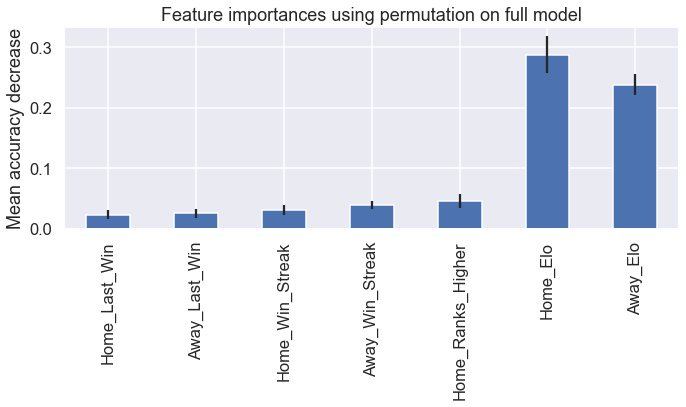

In [147]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, figsize = (10,6))
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Schlussfolgerung und Ausblick

Wie bereits vermutet macht das Elo-Ranking sehr viel aus für das Endresultat.

Wir hatten das Glück, dass wir qualitativ hochwertige Daten gefunden haben. Dies hat dazu geführt, dass wir mehr Zeit in die Features und Learner investieren konnten.

Die Genauigkeit, welche wir schlussendlich Erreicht haben, hat uns positiv Überrascht. Wir denken nicht, dass ein Basketball Spiel noch viel besser vorausgesagt werden kann.

Sobald die Saison 2021 fertig ist, wäre es natürlich noch interessant wie gut unser Modell zmB. die Play-Offs voraussagen kann. Mit diesen Erkenntnissen könnte man sich vieleicht eine geeignete Wettstrategie zusammenstellen.